# Joachim Mąkowski INF141278

# Analiza i testy statystyczne na przykładzie danych o PKB

## Przygotowywanie i sprzątanie danych

In [56]:
#zaimportowanie niezbędnych bibliotek
library(tidyverse)
library(reshape)
library(ggplot2)

In [57]:
region <- read.csv(file = 'Metadata_Country_API_NY.GDP.PCAP.KD_DS2_en_csv_v2_1068878.csv')
#head(region)

In [58]:
gdp <- read.csv('API_NY.GDP.PCAP.KD_DS2_en_csv_v2_1068878.csv')
#head(gdp)

Dane pochodzą z obserwacji. są to dane dotyczące produktu krajowego brutto na mieszkańca. Pobrałem je ze strony: 
https://data.worldbank.org/indicator/NY.GDP.PCAP.KD
Wartości w danych są przedstawione w dolarach amerykańskich pomniejszone/powiększone o inflacje/deflacje dolara amerykańskiego. Będę badał dane tylko od 1990 roku.

In [59]:
gdp <- gdp %>% select(Country.Name,X1990:X2018) # wyrzucenie zbędnych kolumn
#head(gdp)

In [60]:
names(gdp) <- c('Country_Name',1990:2018) #zmiana nazw na wygodniejsze
#head(gdp)

In [61]:
gdp <- na.omit(gdp) #usunięcie krajów z wartościami NA
#head(gdp)

In [62]:
gdp <- merge(x = gdp,y = region,by.x = 'Country_Name',by.y = 'TableName') # połączenie dzięki któremu uzyskujemy dostęp do 
                                    #informacji o regionie w którym znajduje się państwo i do której grupy przychodów należy
#head(gdp)

In [63]:
gdp <- gdp %>% select('Country_Name':'2018',IncomeGroup,Region) #wyrzucenie zbędnych kolumn
#head(gdp)

In [64]:
gdp <- filter(gdp,Region != '')#wyrzucenie danych dla regionów (ponieważ w zbiorze danych znajdowały się informacje o PKB poszczególnych regionów)

## Analiza eksploracyjna 

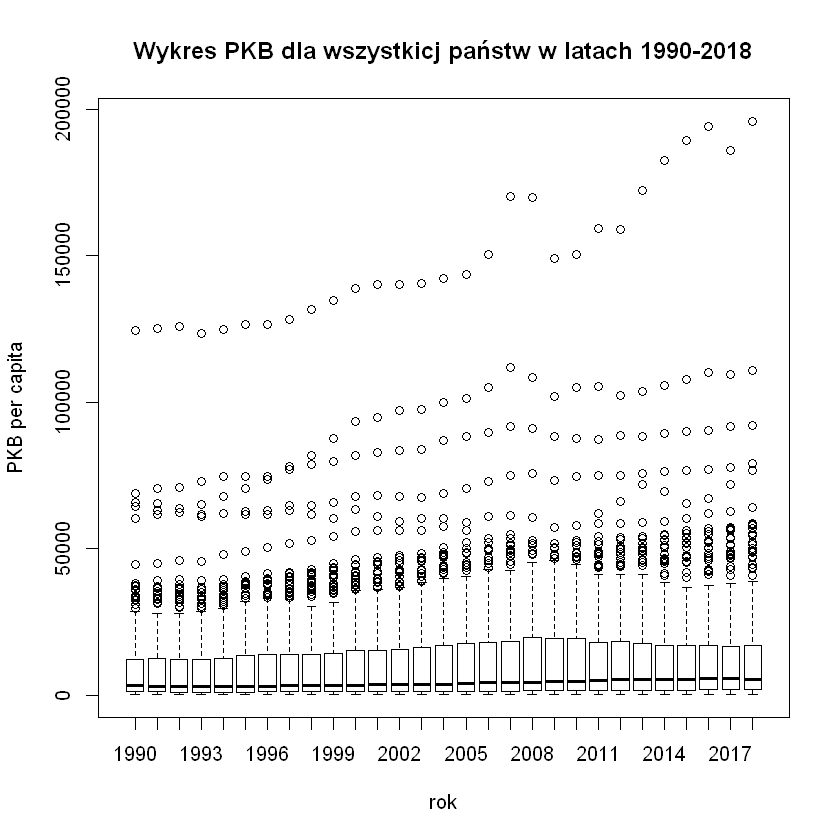

In [65]:
od1990do2018 <- gdp[c(1:30)] # wybór tylko nazwy kraju i wartości PKB
od1990do2018 <- melt(od1990do2018,id = c('Country_Name'))#przerzucenie kolumn z rokiem do wierszy (wygodniejsza praca ze zbiorem)
plot(od1990do2018$variable,od1990do2018$value,xlab = 'rok',ylab = 'PKB per capita',main = 'Wykres PKB dla wszystkicj państw w latach 1990-2018')

Na wykresie widać nieznaczą zmianę mediany w latach 1990-2018, natomiast zmienia się rozstęp międzykwartylowy (największy w latach 2008-2010), oraz liczba outlierów (największa w roku 2018), co pozwala nam sądzić, że coraz więcej narodów jest bogatych, a kraje biedne nie zmieniają swojego statusu materialnego.

In [66]:
od1990do2018$variable <- as.integer(as.character(od1990do2018$variable)) #zmiana typu danych na całkowitoliczbowe

In [67]:
oddoregion <- merge(x = od1990do2018,y = region,by.x = 'Country_Name',by.y = 'TableName')
oddoregion <- oddoregion %>% select('Country_Name':'value','Region','IncomeGroup')

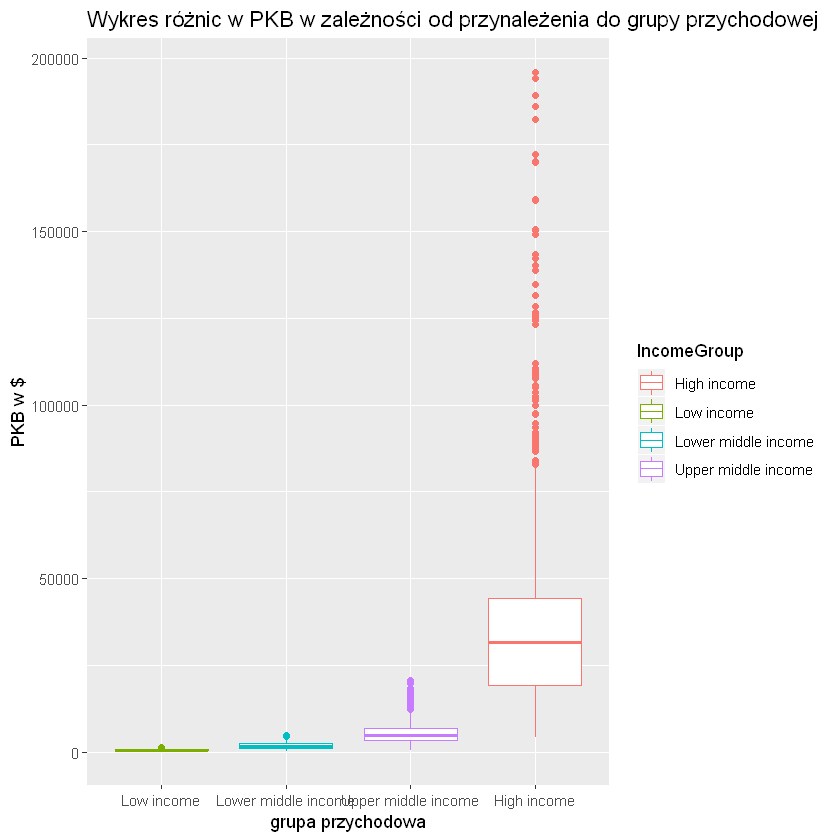

In [68]:
ggplot(oddoregion,aes(x = reorder(IncomeGroup,value, FUN = median), y = value,color = IncomeGroup),las = 3) + geom_boxplot()+ labs(x = 'grupa przychodowa',y ='PKB w $',title = 'Wykres różnic w PKB w zależności od przynależenia do grupy przychodowej')

Z wykresu można zauważyć, że im wyższe PKB tym w lepszej grupie dochodowej jest państwo.

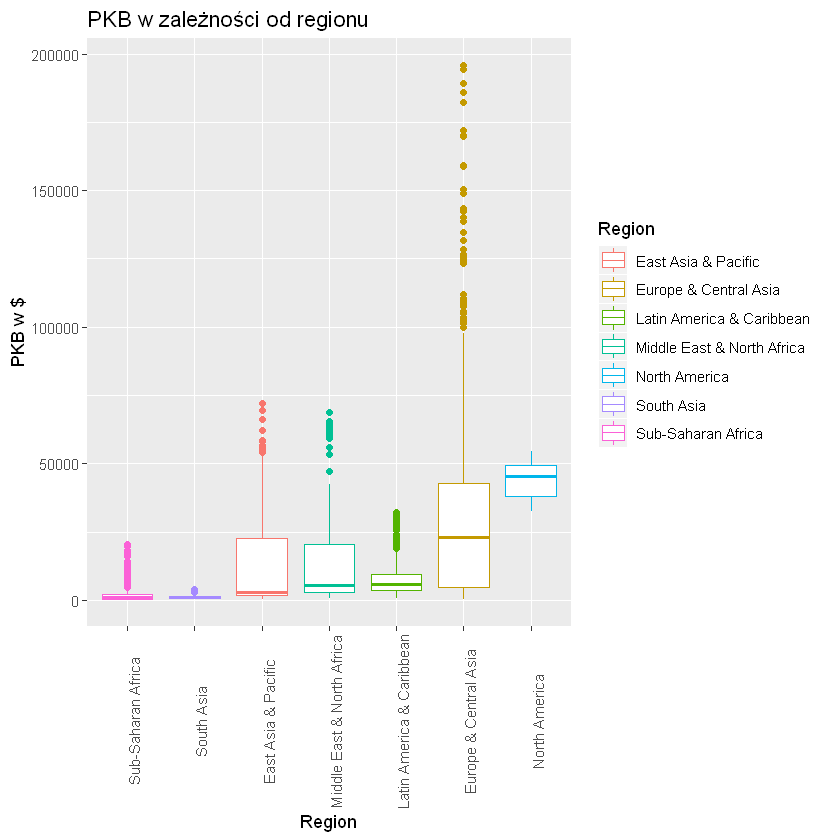

In [69]:
ggplot(oddoregion,aes(x = reorder(Region,value, FUN = median), y = value,color = Region),las = 3) + geom_boxplot()+ labs(x = 'Region',y ='PKB w $',title = 'PKB w zależności od regionu')+theme(axis.text.x = element_text(angle = 90))

Na wykresie widać, że najwyższa mediana jest w Północnej Ameryce, natomiast najbogatsze kraje znajdują się w Europie i centralnej Azji. Najbiedniejszym regionem jest południowa Afryka (na południe od Sahary), natomiast w południowej Azji nie ma żadnego bogatego państwa

## Test statystyczny

Test F-Snedecora

H0: czas nie ma wpływu na PKB (PKB nie jest zależne od czasu) B1 = 0

H1: istnieje zależność między czasem a PKB B1 =/= 0

In [70]:
set.seed(5)
proba <- od1990do2018[sample(c(1:length(od1990do2018$value)),100),]
model <- lm(value ~ variable, proba)
model


Call:
lm(formula = value ~ variable, data = proba)

Coefficients:
(Intercept)     variable  
  -393555.5        203.4  


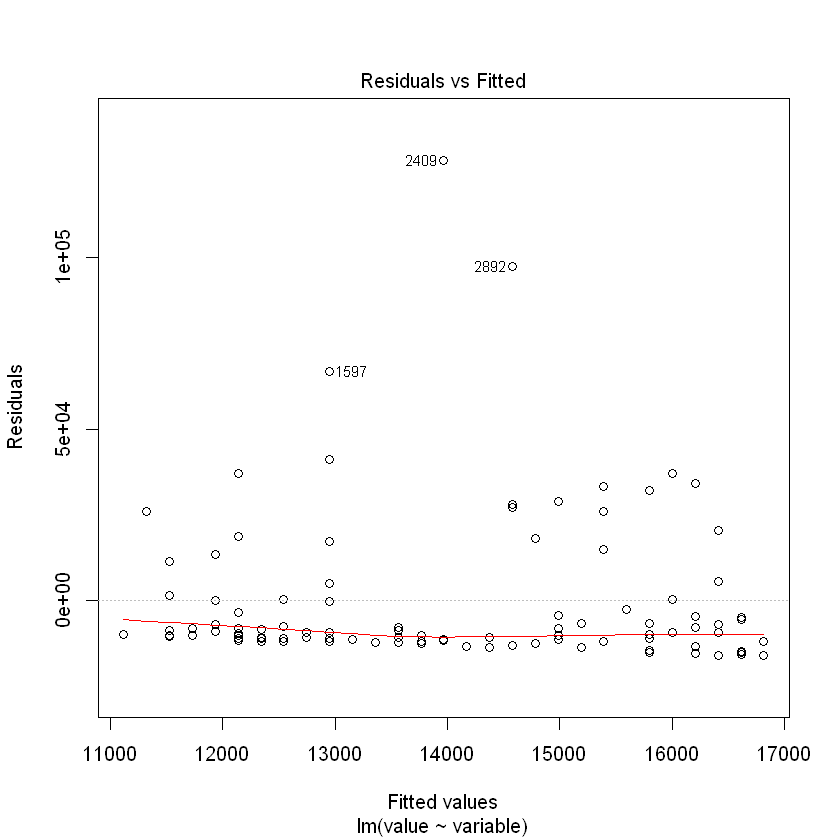

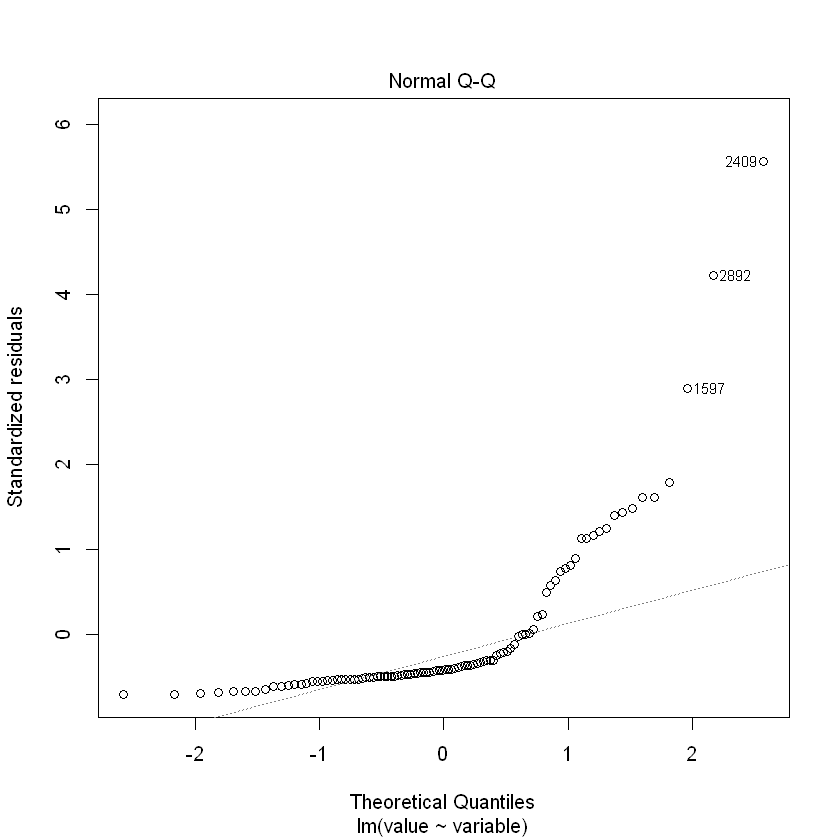

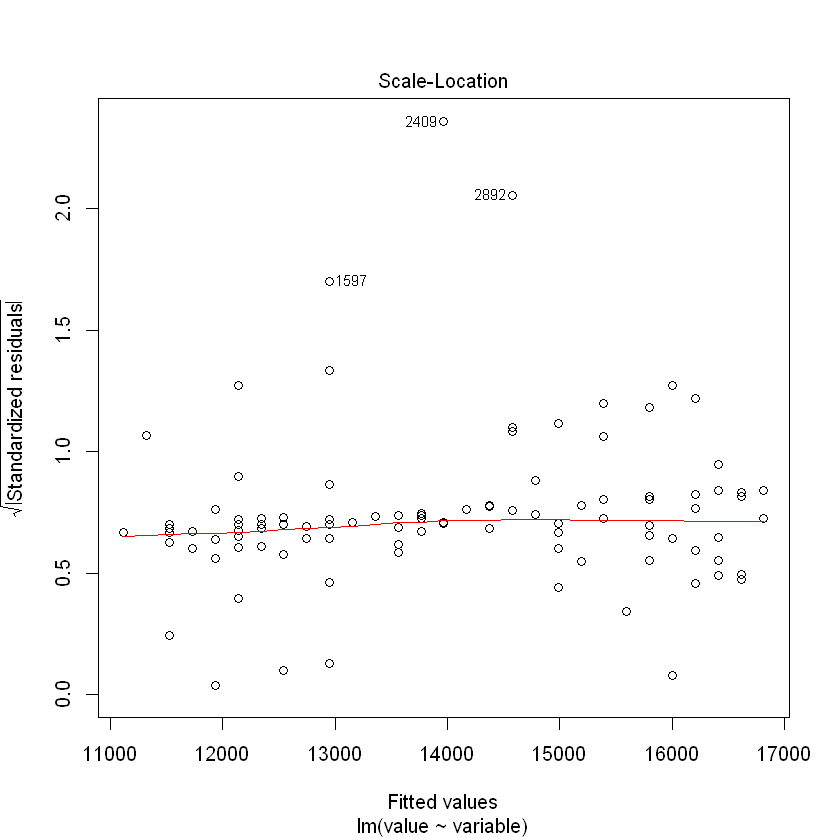

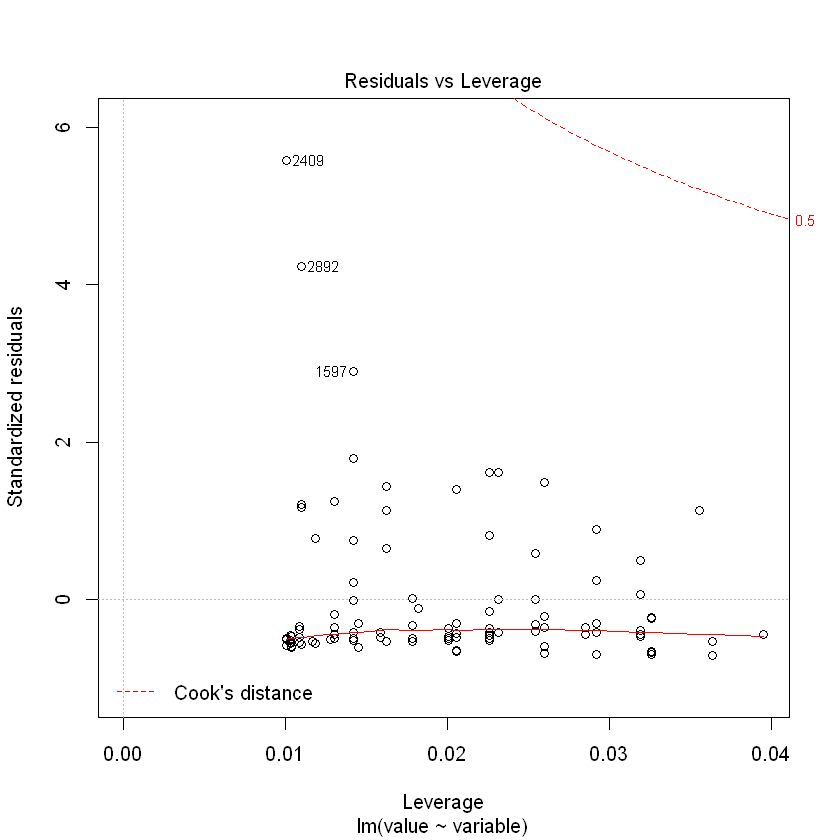

In [71]:
plot(model)

dane nie są liniowe, kwantyle nie mają rozkładu normalnego, odchylenie standardowe jest zależne od roku.

In [72]:
Yp <- model$fitted.values
#Yp

In [73]:
srednia <- mean(proba$value)
sst <- sum((proba$value - srednia)^2)
sse <- sum((proba$value - Yp)^2)
ssr <- sum((Yp - srednia)^2)
ssr

[1] 290053344

In [74]:
test_f <- (ssr/sse)*(length(proba)-2)
test_f

[1] 0.005519528

Dla poziomu istotności alfa = 0.05, wartość krytyczna testu F(1;98) wynosi około 3,94, czyli przedział krytyczny to: (3,94;inf). Nie możemy odrzucić H0, co oznacza, że zmienne mogą być niezależne.

[1] 0.07408934

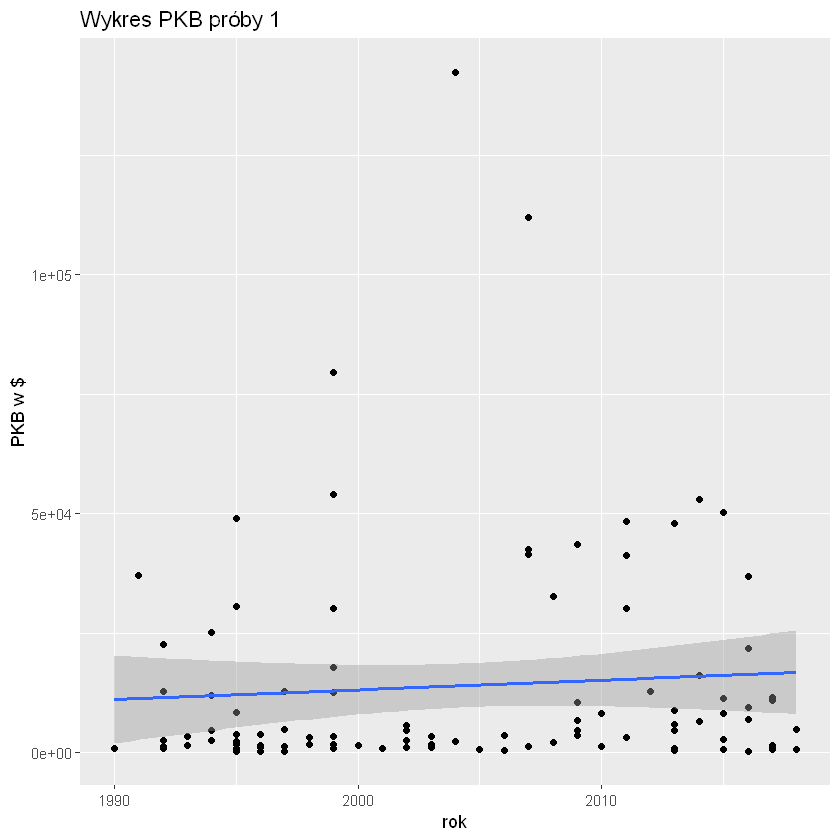

In [75]:
ggplot(proba,aes(x=variable,y=value),las = 1)+geom_point()+geom_smooth(method = 'lm')+ labs(x = 'rok',y ='PKB w $',title = 'Wykres PKB próby 1')
cor(proba$variable,proba$value)

[1] 0.1729438

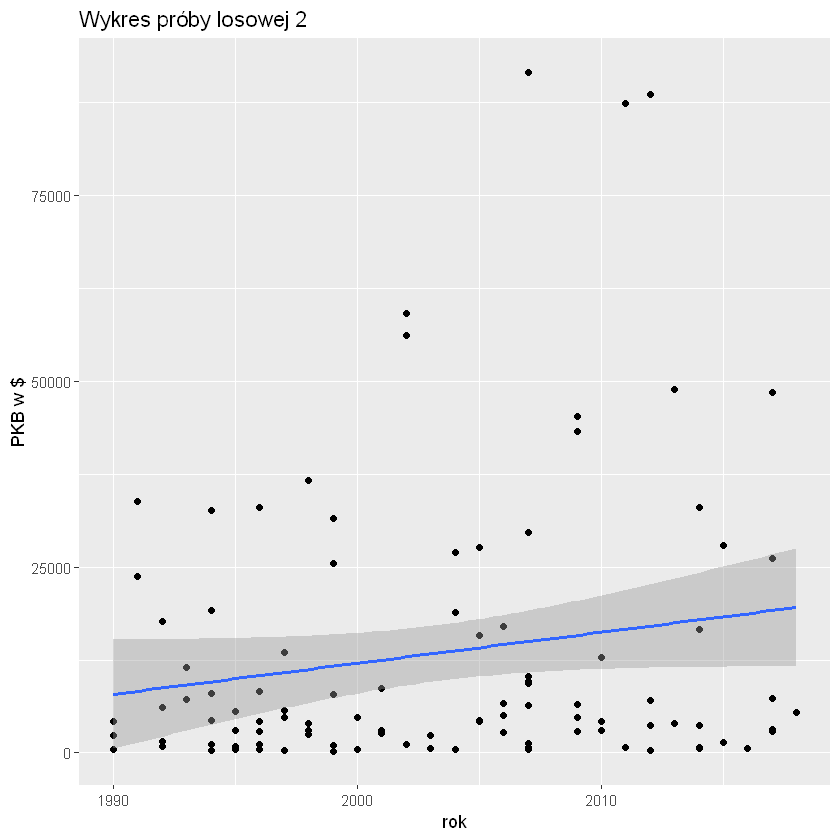

In [76]:
set.seed(50)
proba <- od1990do2018[sample(c(1:length(od1990do2018$value)),100),]
ggplot(proba,aes(x=variable,y=value),las = 1)+geom_point()+geom_smooth(method = 'lm')+ labs(x = 'rok',y ='PKB w $',title = 'Wykres próby losowej 2')
cor(proba$variable,proba$value)

Zarówno próba pierwsza jak i druga nie nadają się do tworzenia regresji liniowej, ponieważ różnice pomiędzy państwami są zbyt duże i w nie wszystkich państwach PKB rośnie liniowo. 

## Regresje 

Widać, że w przypadku obu prób losowych współczynnik korelacji jest niewielki. Jest to efekt, tego że różne państwa w znaczącym stopniu różnią się od siebie i w jednej próbce nie powinny się znaleźć państwa z Afryki i Europy zachodniej, ponieważ PKB na przykład Niemiec znacznie zawyża wszystkie statystyki. Dlatego warto się przyjrzeć PKB każdego państwa z osobna.

In [77]:
wyciaganie_danych <- function(country){
    kraj <- od1990do2018[od1990do2018$Country_Name == country,]
    ggplot(kraj,aes(x = variable, y= value),xlab = 'rok',ylab = 'PKB per capita')+geom_point()+geom_smooth(method = 'lm')
    return (kraj)
}

[1] 0.9862916

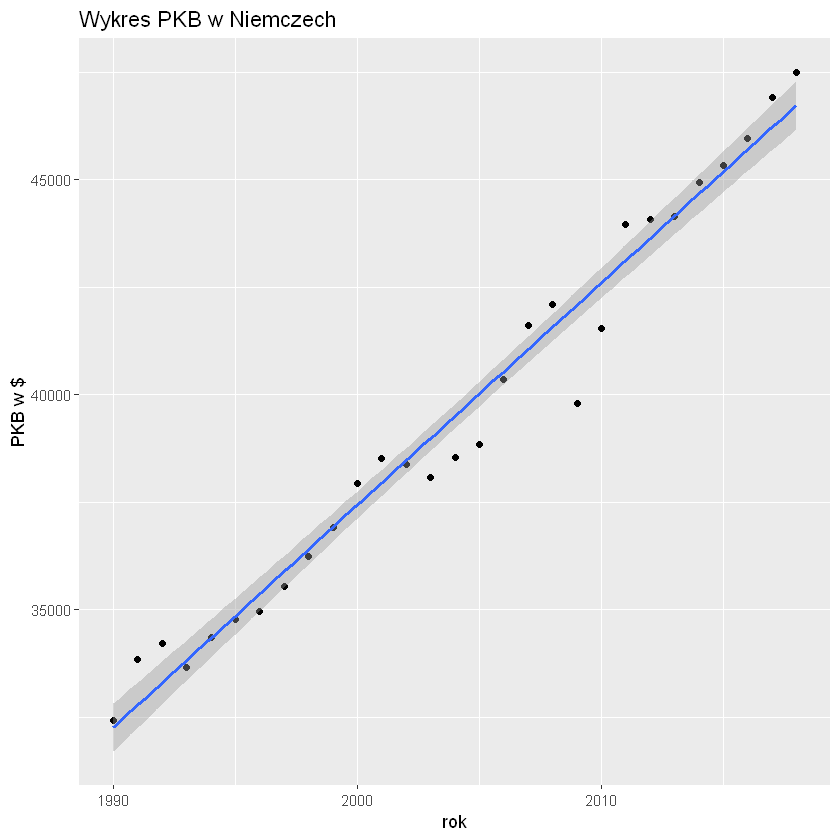

In [78]:
niemcy <- wyciaganie_danych('Germany')
ggplot(niemcy,aes(x = variable, y= value),xlab = 'rok',ylab = 'PKB per capita')+geom_point()+geom_smooth(method = 'lm')+ labs(x = 'rok',y ='PKB w $',title = 'Wykres PKB w Niemczech')
cor(niemcy$variable,niemcy$value)

[1] 0.9862916

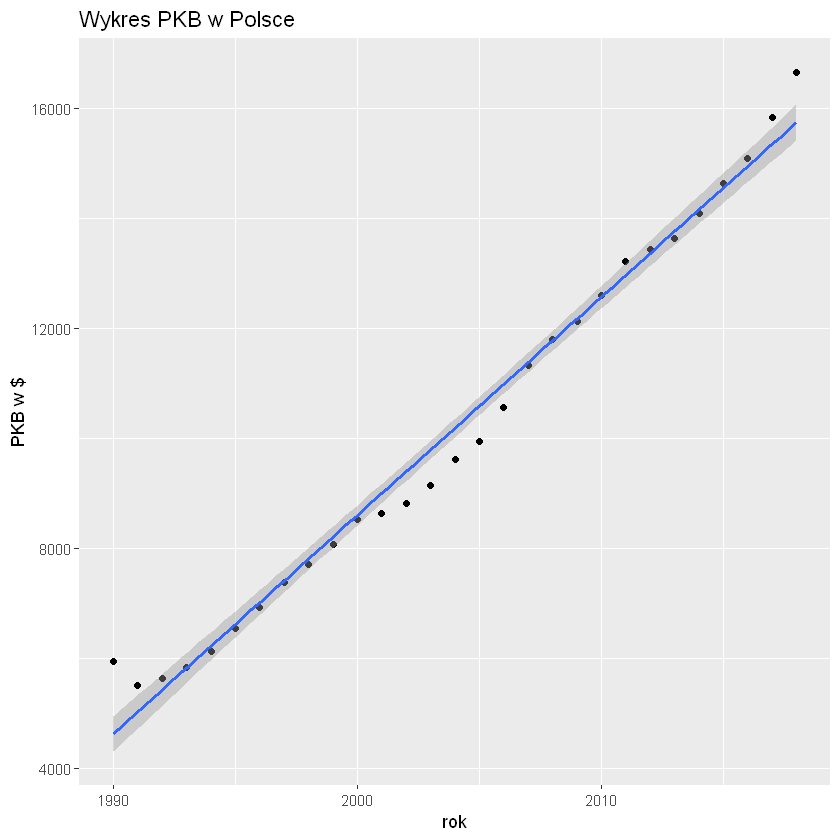

In [79]:
polska <- wyciaganie_danych('Poland')
ggplot(polska,aes(x = variable, y= value),xlab = 'rok',ylab = 'PKB per capita')+geom_point()+geom_smooth(method = 'lm') + labs(x = 'rok',y ='PKB w $',title = 'Wykres PKB w Polsce')
cor(polska$variable,niemcy$value)

Widzimy, że zarówno Niemcy jak i Polska mają prawie liniowy wzrost PKB.

[1] -0.4509453

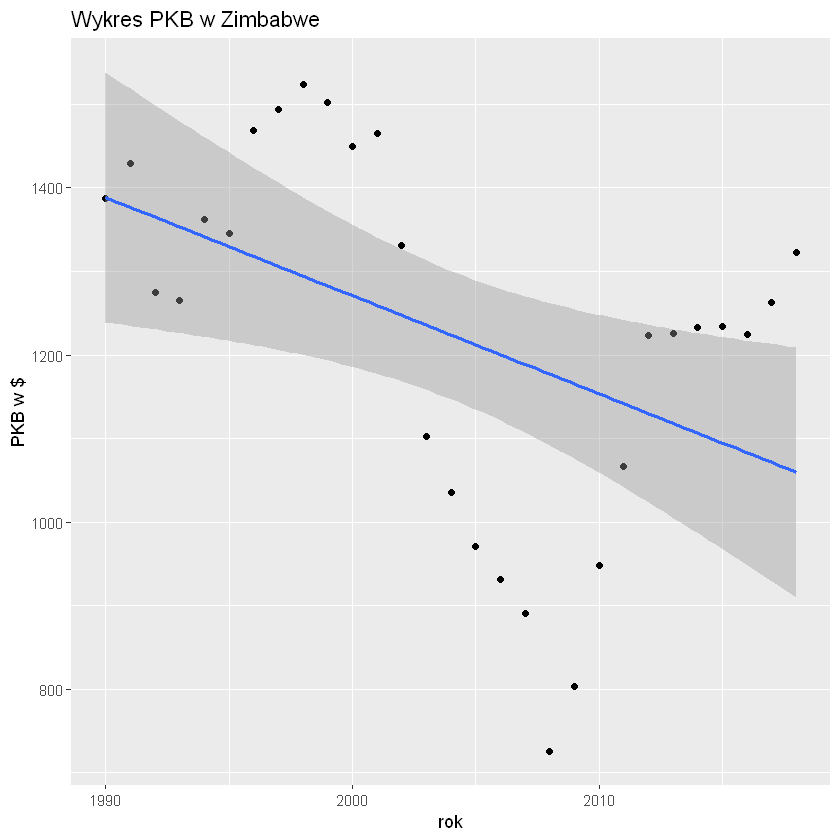

In [80]:
zimbabwe <- wyciaganie_danych('Zimbabwe')
ggplot(zimbabwe,aes(x = variable, y= value),xlab = 'rok',ylab = 'PKB per capita')+geom_point()+geom_smooth(method = 'lm')+ labs(x = 'rok',y ='PKB w $',title = 'Wykres PKB w Zimbabwe')
cor(zimbabwe$value,zimbabwe$variable)

Natomiast kształt wykresu Zimbabwe bardziej przypomina sinusoidę, więc można stwierdzić, że są państwa, które mają silnie skorelowany wzrost PKB z czasem, ale są też państwa w których nie można stosować regresji do predykcji przyszłego PKB.

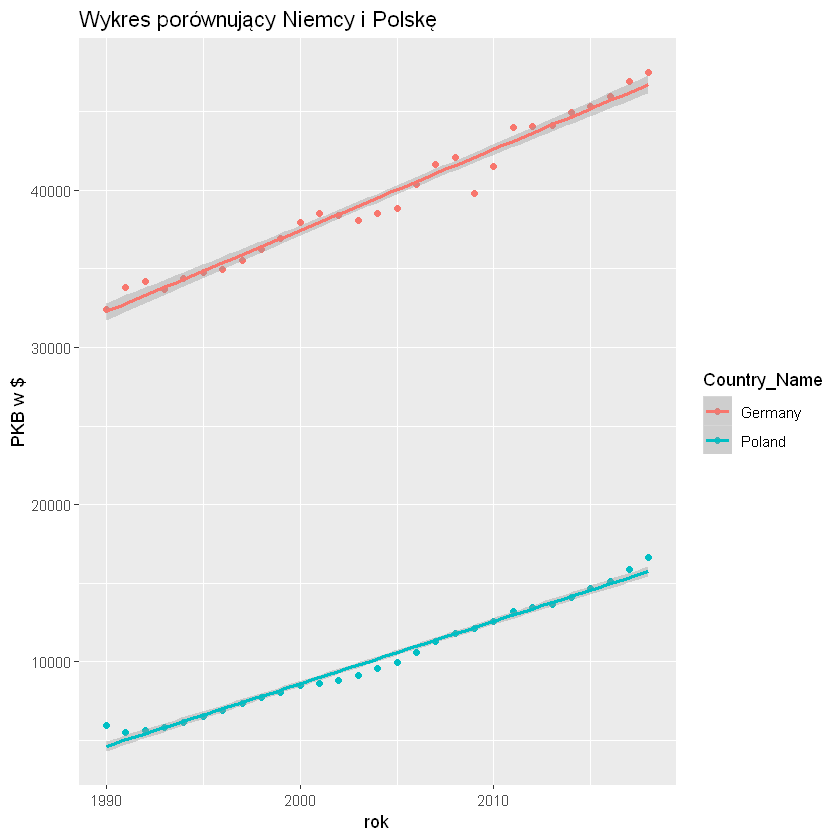

In [81]:
polska_niemcy  <- od1990do2018[od1990do2018$Country_Name == 'Poland' | od1990do2018$Country_Name == 'Germany' ,]
ggplot(polska_niemcy,aes(x = variable, y= value,color = Country_Name))+geom_point()+geom_smooth(method = 'lm') + labs(x = 'rok',y ='PKB w $',title = 'Wykres porównujący Niemcy i Polskę')

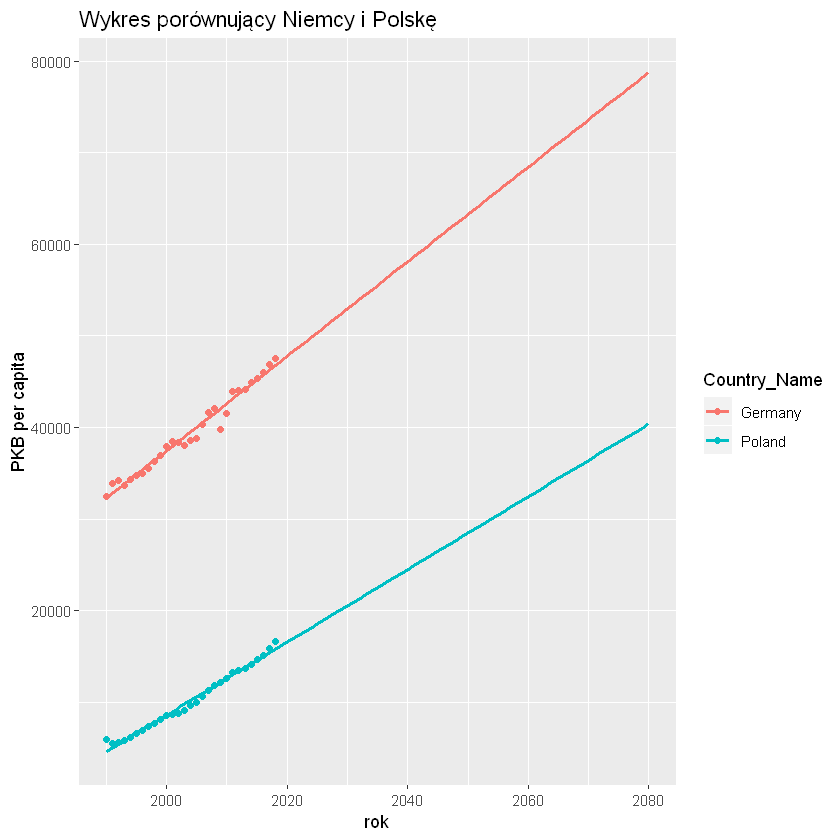

In [82]:
ggplot(polska_niemcy,aes(x = variable, y= value,color = Country_Name))+geom_point()+geom_smooth(method = 'lm',se=FALSE,fullrange = TRUE)+xlim(1990,2080) + labs(x = 'rok',y ='PKB per capita',title = 'Wykres porównujący Niemcy i Polskę')

Jak widać na tym wykresie tempo rozwoju Niemiec od roku 1990 jest szybsze od rozwoju Polski i jeśli się utrzyma to nigdy nie dogonimy Niemiec pod względem rozwoju gospodarczego. Ten wykres zakłada, że utrzymamy tempo rozwoju, ale w sensie że całkowita wartość przyrostu PKB będzie stała w każdym roku. Natomiast rządy państw starają się utrzymać stałe tempo rozwoju, ale w sensie procentowym, czyli na przykład wzrost o 3% PKB co roku skutkuje powstaniem wykresu wykładniczego ze wzrostem 1,03. Więc wzrost o 1% w Niemczech na przestrzeni tych 28 lat powoduje, że w regresji występuje większy przyrost rok do roku, niż w Polsce z przyrostem 3%, ale dane przedstawione na wykresie mają wyraźnie kształt liniowy (wysoki współczynnik korelacji Pearsona), więc sądzę, że zasadnym jest stosowanie w tym przypadku regresji liniowej.